- AutoML: 사용자가 직접 머신러닝 모델을 튜닝하지 않아도 최적의 조합을 자동으로 탐색.

# iris_data를 xgboost로 적용을 해보자.

In [ ]:
#import packages
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris

#Loading iris dataset from sklearn
iris = load_iris()

#independent feautres
X = iris.data

# target features
y = iris.target

In [ ]:
#import XGboost
from xgboost import XGBClassifier

#Defining XGB Classification model
clf = XGBClassifier()

- xgboost의 단점은 복잡한 하이퍼 파라미터가 있다.

# 1.Grid SearchCV
- 사용자가 하이퍼 파라미터마다 몇가지 값을 가진 리스트를 입력하면, 가능한 하이퍼 파라미터의 경우의 수마다 예측 성능을 측정하여 사용자가 일일이 하이퍼 파라미터를 설정하고, 예측 성능을 비교하여 최적의 파라미터를 찾는 수고를 줄이고 이 과정을 한꺼번에 진행한다.

In [ ]:
#Importing packages from sklearn

from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics

#defining a set of values as a dictionary for hyperparameters

param_grid = {
    "n_estimators":[100,200,300,400],
    "max_depth":[1,3,5,7],
    "reg_lambda":[.01,.1,.5]
}

#declaring GridSearchCV model

model = model_selection.GridSearchCV(
    estimator = clf,
    param_grid = param_grid,
    scoring = 'accuracy',
    verbose = 10,
    n_jobs = 1,
    cv = 5
)

#fitting values to the gridsearchcv model

model.fit(X,y)
#printing the best possible values to enhance accuracy
print(model.best_params_)
print(model.best_estimator_)
#printing the best score
print(model.best_score_)
#GridSearchCV model save
# import joblib
# joblib.dump(model, 'model_xgboost.pkl')
# joblib.load('model_xgboost.pkl')

# 2.RandomizedSearchCV

- 그리드 서치에서는 grid_param과 같이 매개변수마다 특정 값을 지정해주었습니다. 만약에 변수 범위가 너무 다양하다면 하나하나 작성해주는게 너무 힘들다.

- 하이퍼 파라미터 검색 반영이 너무 클때 사용하는 방식이 Randomized Search입니다.


In [ ]:
#defining a set of values as a dictionary for hyperparameters

param_grid = {
    "n_estimators":[100,200,300,400],
    "max_depth":[1,3,5,7],
    "reg_lambda":[.01,.1,.5]
}

#declaring RandomizedSearchCV model

model = model_selection.RandomizedSearchCV(
    estimator = clf,
    param_distributions = param_grid,
    scoring = 'accuracy',
    verbose = 10,
    n_jobs = 1,
    cv = 5,
    n_iter=10
)

#fitting values to the RandomizedSearchCV model

model.fit(X,y)

#printing the best possible values to enhance accuracy

print(model.best_params_)
print(model.best_estimator_)
#printing the best score
print(model.best_score_)

# 3.Bayesian optimization

- 참고 : https://data-scientist-brian-kim.tistory.com/88

Bayesian Optimization 은 어느 입력값(x)를 받는 미지의 목적 함수 (f(x))를 판단하고 결정하여, 해당 함숫값 (f(x))을 최대로 만드는 최적해를 찾는 것을 목적으로 합니다.

즉, 목적 함수(탐색대상함수)와 하이퍼파라미터 쌍(pair)을 대상으로 Surrogate Model(대체 모델) 을 만들고,
순차적으로 하이퍼 파라미터를 업데이트해 가면서 평가를 통해 최적의 하이퍼파라미터 조합을 탐색합니다.
이 때의 목적 함수를 black-box function 이라고 합니다.
Bayesian Optimization 에는 두 가지 필수 요소가 존재합니다.

먼저 Surrogate Model 은, 현재까지 조사된 입력값-함숫결과값 점들 $(x_1, f(x_1)),...,(x_t, f(x_t))$ 을 바탕으로, 미지의 목적 함수의 형태에 대한 확률적인 추정을 수행하는 모델을 지칭합니다. 그리고 Acquisition Function 은, 목적 함수에 대한 현재까지의 확률적 추정 결과를 바탕으로, ‘최적 입력값을 찾는 데 있어 가장 유용할 만한’ 다음 입력값 후보를 추천해 주는 함수를 지칭합니다.

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fb33tsP%2FbtraMpvxJG0%2FSn7uQK7k910IQ7cP3ZM9vk%2Fimg.png'>

- 대략적인 수행 과정

    - 위의 파란색 선은, 우리가 찾으려고 하는 목적함수 f(x) 를 나타내고,
    - 검정색 점선은, 지금까지 관측한 데이터를 바탕으로 우리가 예측한 estimated function 을 의미합니다.
    - 검정색 점선 주변에 있는 파란 영역은, 목적함수 f(x) 가 존재할만한 confidence bound(function의 variance) 를 의미합니다.
    - 밑에 있는 EI(x) 는, Acquisition function 을 의미하며, 다음 입력값 후보 추천 시 사용됩니다.
    - Acquisition function 값이 컸던 지점을 확인하고, 해당 지점의 hyperparameter 를 다음 입력 값으로 사용합니다.
    - hyperparamter 에 따라 estimated function 을 계속 update 하면, estimation function 과 목적 함수 f(x) 가 흡사해집니다.
    - 관측한 지점 중 best point 을 argmax f(x) 로 선택합니다.
- 자세한 수행 과정

    - 입력값, 목적 함수 및 그 외 설정값들을 정의합니다.

        - 입력값 x : 여러가지 hyperparameter
        - 목적 함수 f(x) : 설정한 입력값을 적용해 학습한, 딥러닝 모델의 성능 결과 수치(e.g. 정확도)
        - 입력값 x 의 탐색 대상 구간 : (a,b)
        - 입력값-함숫결과값 점들의 갯수 : n
        - 조사할 입력값-함숫결과값 점들의 갯수 : N
    - 설정한 탐색 대상 구간 (a,b) 내에서 처음 n 개의 입력값들을 랜덤하게 샘플링하여 선택합니다.

    - 선택한 n 개의 입력값 x1, x2, ..., xn 을 각각 모델의 hyperparameter 로 설정하여 딥러닝 모델을 학습한 뒤, 학습이 완료된 모델의 성능 결과 수치를 계산합니다.

        - 이들을 각각 함숫결과값 f(x1), f(x2), ..., f(xn) 으로 간주합니다.
입력값-함숫결과값 점들의 모음 (x1, f(x1)), (x2, f(x2)), ..., (xn, f(xn)) 에 대하여 Surrogate Model 로 확률적 추정을 수행합니다.

    - 조사된 입력값-함숫결과값 점들이 총 N 개에 도달할 때까지, 아래의 과정을 반복적으로 수행합니다.

        - 기존 입력값-함숫결과값 점들의 모음 (x1, f(x1)),(x2, f(x2)), ..., (xt, f(xt)) 에 대한 Surrogate Model 의 확률적 추정 결과를 바탕으로, 입력값 구간 (a,b) 내에서의 EI 의 값을 계산하고, 그 값이 가장 큰 점을 다음 입력값 후보 x1 로 선정합니다.
        - 다음 입력값 후보 x1 를 hyperparameter 로 설정하여 딥러닝 모델을 학습한 뒤, 학습이 완료된 모델의 성능 결과 수치를 계산하고, 이를 f(x1) 값으로 간주합니다.
        - 새로운 점 (x2, f(x2)) 을 기존 입력값-함숫결과값 점들의 모음에 추가하고, 갱신된 점들의 모음에 대하여 Surrogate Model 로 확률적 추정을 다시 수행합니다.
        - 총 N 개의 입력값-함숫결과값 점들에 대하여 확률적으로 추정된 목적 함수 결과물을 바탕으로, 평균 함수 μ(x) 을 최대로 만드는 최적해를 최종 선택합니다. 추후 해당값을 hyperparameter 로 사용하여 딥러닝 모델을 학습하면, 일반화 성능이 극대화된 모델을 얻을 수 있습니다.

In [ ]:
def black_box_function(x, y):
    """Function with unknown internals we wish to maximize.

    This is just serving as an example, for all intents and
    purposes think of the internals of this function, i.e.: the process
    which generates its output values, as unknown.
    """
    return -x ** 2 - (y - 1) ** 2 + 1

In [ ]:
!pip install bayesian-optimization

In [ ]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'x': (2, 4), 'y': (-3, 3)}

optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    random_state=1,
)

- n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.

- init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.

In [ ]:
optimizer.maximize(
    init_points=2,
    n_iter=3,
)

In [ ]:
print(optimizer.max)

In [ ]:
for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

In [ ]:
optimizer.set_bounds(new_bounds={"x": (-2, 3)})

optimizer.maximize(
    init_points=0,
    n_iter=5,
)


- 직관적인 이해

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
#확률적 회귀 모델, 데이터 포인트 사이의 관계를 확률분포로 모델링 하는 것.
# 특징 : 비선형 관계를 학습할 수 있음. 샘플 개수가 적어도 신뢰성 있는 예측할수 있다.
# 특징 : 불확실성 정량적으로 평가 가능. / 커널 : 데이터 포인트 사이의 유사도를 측정하는 함수.
# 가우시안 프로세스(GP)에서 커널은 "이 점과 저 점이 얼마나 비슷한가?"
#RBF(Radial Basis Function,aka Gaussian kernel)
# 가장 부드러운 커널. 모든 점이 서로 영향을 미칠 가능성이 있음.
# Matern 커널 : RBF보다는 매끄럽지는 않음. 함수의 거칠기(roughtness)조절할 수 있음.
# -> RBF : 매우 부드러운 변화를 가짐. / Matern : 덜 부드럽고 급격한 변화도 허용.
from sklearn.gaussian_process.kernels import Matern, RBF

# 목적 함수 (최적화할 함수)
# 주어진 x 값에 대해 비선형 함수의 값을 반환
# 이 함수는 최적화를 수행할 대상이며, 샘플링을 통해 최적값을 찾아간다.
def objective_function(x):
    return np.sin(3*x) + x**2 - 0.7*x

# 획득 함수 (Expected Improvement, EI)
# 현재까지의 샘플링 데이터를 기반으로 획득 함수 값을 계산하여, 다음 샘플링할 최적의 지점을 결정한다.
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    mu, sigma = gpr.predict(X, return_std=True)
    sigma = sigma.reshape(-1, 1)  # 2D 형태 유지
    mu_sample = gpr.predict(X_sample)
    mu_sample_opt = np.max(mu_sample)

    # np.errstate를 사용하여 경고 메시지를 제어
    # divide='warn': 0으로 나누는 연산이 발생할 경우 경고를 발생시키고 오류를 방지
    with np.errstate(divide='warn'):
        improvement = mu - mu_sample_opt - xi
        Z = improvement / sigma  # sigma가 0일 경우 문제가 발생할 수 있음
        ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)

        ei = ei.flatten()  # 1D 배열로 변환
        sigma = sigma.flatten()  # 1D 배열로 변환

        if ei.shape == sigma.shape:
            ei[sigma == 0.0] = 0.0  # 0인 값 처리

    return ei

# 베이지안 최적화 실행 함수
# 초기 샘플링 데이터를 기반으로 가우시안 프로세스를 학습하며, 최적의 지점을 찾아간다.
def bayesian_optimization(n_iterations=10, n_initial=3, kernel_type='Matern'):
    np.random.seed(42)

    # 검색 범위
    X = np.linspace(-1, 2, 100).reshape(-1, 1)

    # 초기 샘플링 데이터
    X_sample = np.random.uniform(-1, 2, size=(n_initial, 1))
    Y_sample = objective_function(X_sample)

    # 커널 선택 (Matern 또는 RBF)
    if kernel_type == 'Matern':
        kernel = Matern(length_scale=0.5, nu=2.5)
    elif kernel_type == 'RBF':
        kernel = RBF(length_scale=0.5)
    else:
        raise ValueError("Invalid kernel type. Choose 'Matern' or 'RBF'")

    # 가우시안 프로세스 모델 설정
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-6)

    for i in range(n_iterations):
        # 모델 학습
        gpr.fit(X_sample, Y_sample)

        # 획득 함수 계산 (Expected Improvement 기반)
        ei = expected_improvement(X, X_sample, Y_sample, gpr)
        X_next = X[np.argmax(ei)]

        # 새로운 데이터 추가(Acquisition Function)
        Y_next = objective_function(X_next.reshape(1, -1))
        X_sample = np.vstack((X_sample, X_next.reshape(-1, 1)))
        Y_sample = np.vstack((Y_sample, Y_next.reshape(-1, 1)))

        # 시각화 (최적화 진행 과정 확인)
        plt.figure(figsize=(8, 5))
        mu, sigma = gpr.predict(X, return_std=True)
        plt.plot(X, objective_function(X), 'r--', label='True Function')
        plt.plot(X, mu, 'b-', label='GP Mean')
        plt.fill_between(X.ravel(), mu - 1.96 * sigma, mu + 1.96 * sigma, alpha=0.2, color='blue')
        plt.scatter(X_sample, Y_sample, c='black', label='Samples')
        plt.axvline(X_next, color='green', linestyle='--', label='Next Sample')
        plt.title(f'Iteration {i+1} (Kernel: {kernel_type})')
        plt.legend()
        plt.show()

# 실행 예시 (Matern과 RBF 커널 비교)
bayesian_optimization(kernel_type='Matern')  # Matern 커널 사용
bayesian_optimization(kernel_type='RBF')  # RBF 커널 사용

- xgboost 하이퍼 파라미터 최적화

In [ ]:
#import packages
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris

#Loading iris dataset from sklearn
iris = load_iris()

#independent feautres
X = iris.data

# target features
y = iris.target

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, stratify=y)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb

# MAPE Metric
def mean_absolute_percentage_error(y_test, y_pred):
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# 탐색 대상 함수 (XGBRegressor)
def XGB_cv(max_depth,learning_rate, n_estimators, gamma
            ,min_child_weight, subsample
            ,colsample_bytree, silent=True, nthread=-1):

    # 모델 정의
    model = xgb.XGBRegressor(max_depth=int(max_depth),
                            learning_rate=learning_rate,
                            n_estimators=int(n_estimators),
                            gamma=gamma,
                            min_child_weight=min_child_weight,
                            subsample=subsample,
                            colsample_bytree=colsample_bytree,
                            nthread=nthread
                            )
    # 모델 훈련
    model.fit(X_train, y_train)

    # 예측값 출력
    y_pred= model.predict(X_test)

    # 각종 metric 계산
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # 오차 최적화로 사용할 metric 반환
    return r2

In [ ]:
#  bayesian-optimization 라이브러리의 BayesianOptimization 클래스 import
from bayes_opt import BayesianOptimization
import numpy as np

# 실험해보고자하는 hyperparameter 집합
pbounds = {'max_depth': (3, 7),
            'learning_rate': (0.01, 0.2),
            'n_estimators': (5000, 10000),
            'gamma': (0, 100),
            'min_child_weight': (0, 3),
            'subsample': (0.5, 1),
            'colsample_bytree' :(0.2, 1)
            }

# Bayesian optimization 객체 생성
# f : 탐색 대상 함수, pbounds : hyperparameter 집합
# verbose = 2 항상 출력, verbose = 1 최댓값일 때 출력, verbose = 0 출력 안함
# random_state : Bayesian Optimization 상의 랜덤성이 존재하는 부분을 통제
bo=BayesianOptimization(f=XGB_cv, pbounds=pbounds, verbose=2, random_state=1 )

# 메소드를 이용해 최대화 과정 수행
# init_points :  초기 Random Search 갯수
# n_iter : 반복 횟수 (몇개의 입력값-함숫값 점들을 확인할지! 많을 수록 정확한 값을 얻을 수 있다.)
# acq : Acquisition Function들 중 Expected Improvement(EI) 를 사용 -> 사라짐(2024.04.12)
# xi : exploration 강도 (기본값은 0.0) -> 사라짐(2024.04.12)
bo.maximize(init_points=2, n_iter=10)

# ‘iter’는 반복 회차, ‘target’은 목적 함수의 값, 나머지는 입력값을 나타냅니다.
# 현재 회차 이전까지 조사된 함숫값들과 비교하여, 현재 회차에 최댓값이 얻어진 경우,
# bayesian-optimization 라이브러리는 이를 자동으로 다른 색 글자로 표시하는 것을 확인할 수 있습니다

# 찾은 파라미터 값 확인
print(bo.max)

# 4.Hyperopt

- HyperOpt는 자동화된 하이퍼파라미터 튜닝 프레임워크로서, fmin()이라는 함수 안에는 3가지의 파라미터가 있다:

    - Objective Function: 최소화할 손실 함수
    - Domain Space: 탐색 범위. 베이지안 최적화에서는 이 범위가 각  하이퍼파라미터에 대해 통계 분포를 만들어낸다.
    - Optimization Algorithm : 최적의 조합을 찾기 위한 알고리즘

참고 : https://velog.io/@emseoyk/%ED%95%98%EC%9D%B4%ED%8D%BC%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0-%ED%8A%9C%EB%8B%9D

In [ ]:
!pip install scikit-optimize

In [ ]:
#importing packages

from hyperopt import hp,fmin, tpe, Trials

from hyperopt.pyll.base import scope

from functools import partial

from skopt import space

from skopt import gp_minimize

#defining a method that will perfrom a 5 split cross validation over

#dataset and and will produce the optimum value of the accuracy

def optimize(params, x,y):

    clf = XGBClassifier(**params)

    kf = model_selection.StratifiedKFold(n_splits=5)

    accuracies = []

    for idx in kf.split(X=x,y=y):

        train_idx,test_idx = idx[0],idx[1]

        xtrain = x[train_idx]

        ytrain = y[train_idx]

        xtest = x[test_idx]

        ytest = y[test_idx]

        clf.fit(xtrain,ytrain)

        preds =  clf.predict(xtest)

        fold_acc = metrics.accuracy_score(ytest,preds)

        accuracies.append(fold_acc)

    return -1.0 * np.mean(accuracies)

#defining a set of values as hp for hyperparameters

param_space = {

    "max_depth" : scope.int(hp.quniform("max_depth",3,20, 1)) ,

    "min_child_weight" : scope.int(hp.quniform("min_child_weight",1,8, 1)),

    "n_estimators": scope.int(hp.quniform("n_estimators",100,1500,1)),

    'learning_rate': hp.uniform("learning_rate",0.01,1),

    'reg_lambda': hp.uniform("reg_lambda",0.01,1),

    'gamma': hp.uniform("gamma",0.01,1),

    'subsample': hp.uniform("subsample",0.01,1)

    }

#defiing optimization_fuction as partial and calling optimize within it

optimization_fuction = partial(optimize,x = X, y = y)

trials = Trials()

#Getting the optimum values for hyperparameters

result = fmin(

    fn = optimization_fuction,

    space = param_space,

    algo = tpe.suggest,

    max_evals = 15,

    trials = trials

)

#Printing the best hyperparemeter set

print(result)

# 5.Optuna

- Optuna는 ML 알고리즘의 하이퍼파라미터 튜닝을 자동화해주는 오픈소스 툴입니다. 유사한 툴로 Hyperopt가 있지만 사용성과 문서화, 시각화 제공 여부 등에서 Optuna의 손을 들어주는 경우가 많음.

- 하이퍼파라미터 튜닝에 쓰고 있는 최신 Automl 기법입니다.
- 빠르게 튜닝이 가능하다는 장점이 있음.
- 하이퍼파라미터 튜닝 방식을 지정할수 있다. -> 직관적인 api인 튜닝된 lightgbm도 제공해줍니다.

- 다른 라이브러리들에 비해 직관적인 장점이 있어 코딩하기 용이합니다.


- 거의 모든 ML/DL 프레임워크에서 사용 가능한 넓은 범용성을 가지고 있다.
간단하고 빠르다.
- 최신 동향의 다양한 최적화 알고리즘을 갖추고 있다.
- 병렬 처리가 가능하다.
- 간단한 메소드로 시각화가 가능하다.

- Optuna를 이해하기 위해서는 다음의 용어에 익숙해져야 한다.

    - Study: 목적 함수에 기반한 최적화
    - Trial: 목적함수 시행
- 쉽게 말해 study는 최적화를 하는 과정이고, trial은 다양한 조합으로 목적함수를 시행하는 횟수를 뜻한다.
- Study의 목적은 여러 번의 trial을 거쳐 최적의 하이퍼파라미터 조합을 찾는 것이라고 할 수 있겠다.

- 직관적인 코드(단변수 함수)

In [ ]:
!pip install optuna

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import optuna

# 목적 함수 (최적화할 함수)
# 이 함수는 우리가 최소화하려는 함수로, x에 대해 비선형적인 패턴을 가짐
def objective_function(x):
    return np.sin(3*x) + x**2 - 0.7*x

# Optuna를 활용한 최적화 예시
def optuna_optimization():
    # Optuna의 최적화 대상이 될 목적 함수 정의
    def objective(trial):
        # x 값을 -1에서 2 사이의 연속적인 실수 값으로 탐색하도록 설정
        x = trial.suggest_float("x", -1, 2)
        return objective_function(x)

    # Optuna의 Study 객체 생성 (최소화 문제로 설정)
    study = optuna.create_study(direction="minimize")

    # 최적화를 수행하며, 총 20번의 탐색을 실행
    study.optimize(objective, n_trials=20)

    # 최적해 출력 (최적의 x 값과 해당하는 목적 함수 값)
    print("Best value:", study.best_value)  # 최소화된 함수 값 출력
    print("Best parameter:", study.best_params)  # 최적의 x 값 출력

    # 최적화 진행 과정 시각화 (목적 함수 값이 어떻게 줄어드는지 확인)
    fig = optuna.visualization.matplotlib.plot_optimization_history(study)
    plt.title("Optimization History")
    plt.show()

    # 탐색된 파라미터의 중요도 분석 (어떤 변수가 최적화에 가장 중요한 영향을 미치는지 확인)
    fig = optuna.visualization.matplotlib.plot_param_importances(study)
    plt.title("Parameter Importance")
    plt.show()

# Optuna 최적화 실행 (함수 호출 시 최적화를 시작)
optuna_optimization()

- 직관적인 이해(다변수)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import optuna

# 목적 함수 (최적화할 함수)
# 이 함수는 우리가 최소화하려는 함수로, x에 대해 비선형적인 패턴을 가짐
def objective_function(x, y):
    return np.sin(3*x) + y**2 - 0.7*x*y

# Optuna를 활용한 다변수 최적화 예시
def optuna_optimization():
    # Optuna의 최적화 대상이 될 목적 함수 정의
    def objective(trial):
        # x 값을 -1에서 2 사이의 연속적인 실수 값으로 탐색하도록 설정
        x = trial.suggest_float("x", -1, 2)
        y = trial.suggest_float("y", -2, 2)
        return objective_function(x, y)

    # Optuna의 Study 객체 생성 (최소화 문제로 설정)
    study = optuna.create_study(direction="minimize")

    # 최적화를 수행하며, 총 50번의 탐색을 실행 (다변수 탐색 강화)
    study.optimize(objective, n_trials=50)

    # 최적해 출력 (최적의 x, y 값과 해당하는 목적 함수 값)
    print("Best value:", study.best_value)  # 최소화된 함수 값 출력
    print("Best parameters:", study.best_params)  # 최적의 x, y 값 출력

    # 최적화 진행 과정 시각화 (목적 함수 값이 어떻게 줄어드는지 확인)
    fig = optuna.visualization.matplotlib.plot_optimization_history(study)
    plt.title("Optimization History")
    plt.show()

    # 탐색된 파라미터의 중요도 분석 (어떤 변수가 최적화에 가장 중요한 영향을 미치는지 확인)
    fig = optuna.visualization.matplotlib.plot_param_importances(study)
    plt.title("Parameter Importance")
    plt.show()

    # x와 y 값의 탐색 과정 시각화 (탐색 경로 분석)
    fig = optuna.visualization.matplotlib.plot_contour(study, params=["x", "y"])
    plt.title("Parameter Contour")
    plt.show()

# Optuna 최적화 실행 (다변수 최적화를 수행)
optuna_optimization()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import optuna

# 목적 함수 (최적화할 함수)
# 이 함수는 우리가 최소화하려는 함수로, x에 대해 비선형적인 패턴을 가짐
def objective_function(x, y):
    return np.sin(3*x) + y**2 - 0.7*x*y

# Optuna를 활용한 다변수 최적화 예시 (고급 기능 추가)
def optuna_optimization():
    # Optuna의 최적화 대상이 될 목적 함수 정의
    def objective(trial):
        # x 값을 -1에서 2 사이의 연속적인 실수 값으로 탐색하도록 설정
        x = trial.suggest_float("x", -1, 2)
        y = trial.suggest_float("y", -2, 2)
        return objective_function(x, y)

    # Optuna의 Study 객체 생성 (최소화 문제로 설정)
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
    #TPE (Tree-structured Parzen Estimator) 기반 샘플링 방법, 기존 샘플 데이터로부터 확률 모델을 학습하여, 더 좋은 후보값을 예측
    #기존의 무작위 샘플링보다 빠르고 효율적인 탐색이 가능 / 특히, 하이퍼파라미터 튜닝에서 많이 사용됨

    # 최적화를 수행하며, 총 100번의 탐색을 실행 (탐색 성능 향상)
    study.optimize(objective, n_trials=100)

    # 최적해 출력 (최적의 x, y 값과 해당하는 목적 함수 값)
    print("Best value:", study.best_value)  # 최소화된 함수 값 출력
    print("Best parameters:", study.best_params)  # 최적의 x, y 값 출력

    # 최적화 진행 과정 시각화 (목적 함수 값이 어떻게 줄어드는지 확인)
    fig = optuna.visualization.matplotlib.plot_optimization_history(study)
    plt.title("Optimization History")
    plt.show()

    # 탐색된 파라미터의 중요도 분석 (어떤 변수가 최적화에 가장 중요한 영향을 미치는지 확인)
    fig = optuna.visualization.matplotlib.plot_param_importances(study)
    plt.title("Parameter Importance")
    plt.show()

    # x와 y 값의 탐색 과정 시각화 (탐색 경로 분석)
    fig = optuna.visualization.matplotlib.plot_contour(study, params=["x", "y"])
    plt.title("Parameter Contour")
    plt.show()

    # 하이퍼파라미터의 조합을 3D 산점도로 시각화
    trials = np.array([[t.params["x"], t.params["y"], t.value] for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(trials[:, 0], trials[:, 1], trials[:, 2], c=trials[:, 2], cmap='viridis', marker='o')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("Objective Value")
    plt.title("Optimization Search Space")
    plt.show()

# Optuna 최적화 실행 (다변수 최적화를 수행)
optuna_optimization()

- randomsampler VS TPEsampler

In [ ]:
import optuna
import numpy as np

# 최적화할 목적 함수 정의
def objective(trial):
    x = trial.suggest_float("x", -5, 5)
    y = trial.suggest_float("y", -5, 5)
    return (x - 2) ** 2 + (y + 3) ** 2  # (2, -3)에서 최솟값을 가짐

# Random Sampler (무작위 탐색)
study_random = optuna.create_study(direction="minimize", sampler=optuna.samplers.RandomSampler())
study_random.optimize(objective, n_trials=50)
print("Random Sampler Best Value:", study_random.best_value, "Best Params:", study_random.best_params)

# TPE Sampler (TPE 기반 탐색)
study_tpe = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study_tpe.optimize(objective, n_trials=50)
print("TPE Sampler Best Value:", study_tpe.best_value, "Best Params:", study_tpe.best_params)


- 고급버전(3D)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import optuna
from optuna.trial import TrialState

# 목적 함수 (최적화할 함수)
# 이 함수는 우리가 최소화하려는 함수로, x에 대해 비선형적인 패턴을 가짐
def objective_function(x, y):
    return np.sin(3*x) + y**2 - 0.7*x*y

# Optuna를 활용한 다변수 최적화 예시 (고급 기능 추가)
def optuna_optimization():
    # Optuna의 최적화 대상이 될 목적 함수 정의
    def objective(trial):
        # x 값을 -1에서 2 사이의 연속적인 실수 값으로 탐색하도록 설정
        x = trial.suggest_float("x", -1, 2)
        y = trial.suggest_float("y", -2, 2)
        return objective_function(x, y)

    # Optuna의 Study 객체 생성 (최소화 문제로 설정)
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())

    # 최적화를 수행하며, 총 100번의 탐색을 실행 (탐색 성능 향상)
    study.optimize(objective, n_trials=100)

    # 최적해 출력 (최적의 x, y 값과 해당하는 목적 함수 값)
    print("Best value:", study.best_value)  # 최소화된 함수 값 출력
    print("Best parameters:", study.best_params)  # 최적의 x, y 값 출력

    # 최적화 진행 과정 시각화 (목적 함수 값이 어떻게 줄어드는지 확인)
    fig = optuna.visualization.matplotlib.plot_optimization_history(study)
    plt.title("Optimization History")
    plt.show()

    # 탐색된 파라미터의 중요도 분석 (어떤 변수가 최적화에 가장 중요한 영향을 미치는지 확인)
    fig = optuna.visualization.matplotlib.plot_param_importances(study)
    plt.title("Parameter Importance")
    plt.show()

    # x와 y 값의 탐색 과정 시각화 (탐색 경로 분석)
    fig = optuna.visualization.matplotlib.plot_contour(study, params=["x", "y"])
    plt.title("Parameter Contour")
    plt.show()

    # 하이퍼파라미터의 조합을 3D 산점도로 시각화
    trials = np.array([[t.params["x"], t.params["y"], t.value] for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(trials[:, 0], trials[:, 1], trials[:, 2], c=trials[:, 2], cmap='viridis', marker='o')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("Objective Value")
    plt.title("Optimization Search Space")
    plt.show()

    # 최적화 과정에서 실패한 시도들에 대한 통계 출력
    complete_trials = study.get_trials(states=(TrialState.COMPLETE,))
    failed_trials = study.get_trials(states=(TrialState.FAIL,))
    print(f"Total completed trials: {len(complete_trials)}")
    print(f"Total failed trials: {len(failed_trials)}")

    # 하이퍼파라미터 값 분포 시각화
    fig = optuna.visualization.matplotlib.plot_parallel_coordinate(study)
    plt.title("Parallel Coordinate Plot")
    plt.show()

# Optuna 최적화 실행 (다변수 최적화를 수행)
optuna_optimization()

In [ ]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import optuna
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 데이터 로드
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optuna를 사용한 하이퍼파라미터 최적화
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 50),  # 트리의 리프 노드 개수
        'max_depth': trial.suggest_int('max_depth', -1, 10),  # 트리의 최대 깊이
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),  # 학습률
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),  # 부스팅 반복 횟수
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),  # 샘플링 비율
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),  # 특성 선택 비율
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # L1 정규화
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.0001, 1.0)  # L2 정규화
    }
    model = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', metric='accuracy', **params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='logloss', callbacks=[lgb.early_stopping(50)])
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Optuna 최적화 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", study.best_params)

# 최적 모델 평가
best_params = study.best_params
best_model = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', metric='accuracy', **best_params)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("최적 모델의 정확도:", accuracy)

- 업그레이드 버전

In [ ]:
pip install optuna-integration

- Optuna Integration (optuna-integration)
    - Optuna와 다양한 머신러닝 프레임워크(XGBoost, LightGBM, PyTorch 등)를 쉽게 연동하는 라이브러리
    - optuna.integration.lightgbm.LightGBMPruningCallback을 통해 LightGBM과 Optuna를 쉽게 연결 가능.

In [ ]:
import optuna
import lightgbm as lgb
from optuna.integration import LightGBMPruningCallback
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss

# 데이터 로드
data = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.1),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
    }

    model = lgb.LGBMClassifier(**params)

    # 📌 조기 종료 및 Pruning 설정
    callbacks = [
        LightGBMPruningCallback(trial, "binary_logloss"),  # log loss가 감소하지 않으면 pruning
        lgb.early_stopping(50),  # 50회 동안 개선이 없으면 조기 종료
    ]

    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="logloss",
        callbacks=callbacks  # early_stopping_rounds 대신 사용
    )

    y_pred_prob = model.predict_proba(X_test)[:, 1]  # 클래스 1에 대한 확률
    return log_loss(y_test, y_pred_prob)  # log loss 값 반환 (작을수록 좋음)

# Optuna 최적화 실행 (`direction="minimize"`로 변경)
study = optuna.create_study(direction="minimize")  # log loss는 낮을수록 좋음
study.optimize(objective, n_trials=50)

# 최적의 하이퍼파라미터 출력
print("Best parameters:", study.best_params)

- load_iris()

In [ ]:
#importing all the required packages
import optuna
from sklearn.datasets import load_iris
import sklearn.linear_model
import sklearn.metrics
from sklearn.model_selection import train_test_split

#Loading iris dataset from sklearn
iris = load_iris()

#independent feautres
X = iris.data

# target features
y = iris.target

In [ ]:
# 📌 필요한 패키지 임포트
import optuna  # 하이퍼파라미터 최적화 라이브러리
import numpy as np  # 수치 계산을 위한 numpy
from sklearn import model_selection, metrics  # 교차 검증과 평가 지표
from xgboost import XGBClassifier  # XGBoost 분류기
from functools import partial  # partial() 함수를 사용해 인자를 고정

#  `optimize` 함수 정의
# - 5-Fold 교차 검증을 수행하여 최적의 하이퍼파라미터를 찾음
# - Optuna를 활용해 자동으로 최적의 값을 탐색
def optimize(trial, x, y):
    """
    Optuna를 이용해 XGBoost 모델의 최적 하이퍼파라미터를 찾는 함수.
    5-Fold Cross Validation을 사용하여 모델을 평가하고, 최적의 파라미터를 탐색함.

    Parameters:
        trial (optuna.trial): Optuna의 트라이얼 객체 (각 실험의 파라미터 조정)
        x (numpy.ndarray): 입력 데이터 (Feature)
        y (numpy.ndarray): 출력 데이터 (Label)

    Returns:
        float: 평균 정확도의 음수 값 (최소화를 위해 -1을 곱함)
    """

    #  Optuna를 이용해 하이퍼파라미터 범위 설정
    # - `suggest_uniform`: 연속된 값에서 랜덤 샘플링 (균등 분포)
    # - `suggest_int`: 정수 값 범위에서 랜덤 샘플링
    reg_lambda = trial.suggest_uniform('reg_lambda', 0.01, 1.0)  # L2 정규화 (0.01 ~ 1.0)
    n_estimators = trial.suggest_int('n_estimators', 100, 1500)  # 트리 개수 (100 ~ 1500)
    max_depth = trial.suggest_int('max_depth', 3, 15)  # 트리 최대 깊이 (3 ~ 15)
    max_features = trial.suggest_uniform('max_features', 0.01, 1.0)  # 선택할 특성 비율 (0.01 ~ 1.0)

    #  XGBoost 모델 생성 (하이퍼파라미터 적용)
    clf = XGBClassifier(
        n_estimators=n_estimators,  # 부스팅 반복 횟수
        reg_lambda=reg_lambda,  # L2 정규화 (규제를 통해 과적합 방지)
        max_depth=max_depth,  # 트리의 최대 깊이 (깊을수록 복잡한 모델)
        max_features=max_features  # 특성 선택 비율 (작을수록 모델이 단순해짐)
    )

    #  5-Fold Stratified K-Fold 교차 검증 설정
    # - 데이터를 5개의 Fold로 나눠, 각 Fold마다 모델을 학습 & 평가
    # - `StratifiedKFold`를 사용해 클래스 비율을 유지하도록 설정 (불균형 데이터 방지)
    kf = model_selection.StratifiedKFold(n_splits=5)

    #  교차 검증을 수행하며 정확도를 저장할 리스트
    accuracies = []

    #  각 Fold에 대해 학습 & 평가 반복
    for idx in kf.split(X=x, y=y):
        train_idx, test_idx = idx[0], idx[1]  # 학습 데이터와 검증 데이터의 인덱스 분할

        #  학습 데이터와 검증 데이터 생성
        xtrain, xtest = x[train_idx], x[test_idx]
        ytrain, ytest = y[train_idx], y[test_idx]

        #  모델 학습
        clf.fit(xtrain, ytrain)

        #  검증 데이터에 대한 예측 수행
        preds = clf.predict(xtest)

        #  Fold별 정확도(Accuracy) 계산
        fold_acc = metrics.accuracy_score(ytest, preds)
        accuracies.append(fold_acc)  # 정확도 리스트에 저장

    #  최종적으로 5-Fold 교차 검증 평균 정확도를 반환
    # - Optuna는 기본적으로 최소화(`direction='minimize'`)를 수행하므로, 음수(-1)를 곱해 반환
    return -1.0 * np.mean(accuracies)

#  `partial()`을 이용해 X와 Y 데이터를 `optimize` 함수에 고정
# - `optimize()` 함수의 인자를 고정하여, `study.optimize()`에서 간편하게 호출 가능
optimization_function = partial(optimize, x=X, y=y)

#  Optuna Study 생성 (하이퍼파라미터 최적화 설정)
# - `direction='minimize'`: 가장 낮은 정확도를 찾는 것이 아니라, `-accuracy` 값을 최소화하여 정확도를 최대화하는 구조
study = optuna.create_study(direction='minimize')

#  Optuna 최적화 실행 (15번의 실험 진행)
study.optimize(optimization_function, n_trials=15)

#  최적의 하이퍼파라미터 출력
print("Best Hyperparameters:", study.best_params)


- mimimize로 찾은 이유 : https://stackoverflow.com/questions/72193393/find-the-value-of-variables-to-maximize-return-of-function-in-python

## Create an objective function

In [ ]:
#  Optuna 개념 정리
# - `Trial`: 하나의 실험(객체)으로, objective 함수가 한 번 실행될 때마다 생성됨.
# - `Study`: 여러 개의 `Trial`을 포함하는 하나의 최적화 세션.
# - `Study`는 특정 목표(objective function)에 따라 최적의 하이퍼파라미터를 찾음.
# - `Trial`은 objective 함수를 실행할 때마다 새로운 하이퍼파라미터 값을 평가함.

#  `objective` 함수 정의
# - Optuna가 하이퍼파라미터를 최적화할 때 호출되는 함수.
# - 여기서는 Lasso Regression 모델의 `alpha` 값을 최적화하는 것이 목표.
def objective(trial):

    #  Optuna를 사용한 하이퍼파라미터 탐색
    # - `suggest_uniform(name, low, high)`: 지정한 범위 내에서 균등 분포를 따르는 값을 샘플링함.
    # - 여기서는 `alpha`를 0.0 ~ 2.0 범위에서 최적의 값을 찾음.
    alpha = trial.suggest_uniform('alpha', 0.0, 2.0)

    #  데이터 로드 및 학습/검증 데이터 분할
    # - `load_iris(return_X_y=True)`: Iris 데이터셋을 가져와 X(특성), y(레이블)로 반환.
    X, y = load_iris(return_X_y=True)

    # - `train_test_split()`: 데이터를 학습(train)과 검증(validation) 세트로 분할.
    # - `random_state=0`: 실험의 재현성을 보장하기 위해 랜덤 시드를 고정.
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

    #  모델 학습 및 평가
    # - `sklearn.linear_model.Lasso(alpha=alpha)`: Lasso 회귀 모델 생성 (alpha는 정규화 강도를 조절).
    model = sklearn.linear_model.Lasso(alpha=alpha)

    # - `fit(X_train, y_train)`: 학습 데이터로 모델을 학습.
    model.fit(X_train, y_train)

    # - `predict(X_val)`: 검증 데이터로 예측 수행.
    y_pred = model.predict(X_val)

    #  평가 지표: 평균 제곱 오차(MSE)
    # - `mean_squared_error(y_val, y_pred)`: 예측값과 실제값 간의 평균 제곱 오차를 계산.
    error = sklearn.metrics.mean_squared_error(y_val, y_pred)

    #  최적화 목표: MSE를 최소화하는 방향으로 `alpha` 값을 찾음.
    # - Optuna는 반환된 값을 기준으로 최적의 하이퍼파라미터를 탐색함.
    return error

## Create an study for that ML model and optimize it

In [ ]:
import sklearn
# In Optuna, we use the study object to manage optimization.
# Method :func:`~optuna.create_study` returns a study object.
# A study object has useful properties for analyzing the optimization outcome.
study = optuna.create_study(direction='minimize') #Set minimize for minimization and maximize for maximization.
#To start the optimization, we create a study object and pass the objective function to method
study.optimize(objective, n_trials=50)

## Visualized the above hyperparameter optimization study

In [ ]:
#importing all the plot functions
from optuna.visualization import plot_edf
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

In [ ]:
# Visualize the optimization history. See :func:`~optuna.visualization.plot_optimization_history` for the details.
plot_optimization_history(study)

In [ ]:
# Visualize high-dimensional parameter relationships. See :func:`~optuna.visualization.plot_parallel_coordinate` for the details.
plot_parallel_coordinate(study)

In [ ]:
# Visualize individual hyperparameters as slice plot. See :func:`~optuna.visualization.plot_slice` for the details.
plot_slice(study)

In [ ]:
# Visualize parameter importances. See :func:`~optuna.visualization.plot_param_importances` for the details.
#In this case, we have only one parameter.
plot_param_importances(study)

In [ ]:
# Visualize empirical distribution function. See :func:`~optuna.visualization.plot_edf` for the details.
plot_edf(study)

In [ ]:
import optuna
import sklearn
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

# 1. 최소화/최대화할 목적함수 정의
def objective(trial):
    iris = sklearn.datasets.load_iris()
    x, y = iris.data, iris.target

# 2. trial object로 하이퍼파라미터 값 추천
# 다양한 분류모델을 설정해서 비교할 수 있다.
    classifier_name = trial.suggest_categorical('classifier', ['SVC', 'RandomForest'])
    #분류 모델이 SVC일 때
    if classifier_name == 'SVC':
        svc_c = trial.suggest_loguniform('svc_c', 1e-10, 1e10)
        classifier_obj = sklearn.svm.SVC(C=svc_c, gamma='auto')

    #분류모델이 랜덤포레스트일 때
    else:
        rf_max_depth = int(trial.suggest_loguniform('rf_max_depth', 2, 32))
        classifier_obj = sklearn.ensemble.RandomForestClassifier(max_depth=rf_max_depth, n_estimators=10)

    accuracy = cross_val_score(classifier_obj, x, y, cv = 4).mean()
    return accuracy

# 3. study 오브젝트 생성하고 목적함수 최적화하는 단계
# 여기서는 목적함수를 정확도로 설정했기 때문에 최대화를 목표로 하고 있지만, 손실함수의 경우 direction='minimize'로 설정
study = optuna.create_study(direction='maximize')
# 반복 시행 횟수(trial)는 200번으로
study.optimize(objective, n_trials=200)

In [ ]:
# 시행된 trial 중 최적의 하이퍼파라미터 반환하는 메소드
print(study.best_trial.params)

# 시행된 trial 중 가장 높은 값 반환하는 메소드
optuna_acc = study.best_trial.value
print(optuna_acc)

## Visualization

In [ ]:
optuna.visualization.plot_param_importances(study)

optuna.visualization.plot_optimization_history(study)

#6. TPOT (Tree-based Pipeline Optimization Tool)
- TPOT은 자동 머신러닝(AutoML) 라이브러리 중 하나로, **유전 알고리즘(Genetic Algorithm, GA)**을 활용하여 최적의 머신러닝 파이프라인을 찾아주는 도구

- 여러 개의 모델을 탐색하며, 최적의 Stacking 구조를 찾아줌.
- Python에서 AutoML을 수행하기위한 오픈 소스 라이브러리
- 데이터 변환 및 기계 학습 알고리즘에 인기있는 Scikit-Learn 기계 학습 라이브러리를 사용
- 주어진 데이터 세트에 대한 최고 성능의 모델 파이프 라인을 효율적으로 검색
- 유전 프로그래밍 확률적 글로벌 검색 절차를 사용

<img src='https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fb8ctX7%2Fbtrnji5Ub3h%2FKxKKKtTK0TMtC83zUaVnq1%2Fimg.png'>

## 유전 알고리즘

- **유전 알고리즘(Genetic Algorithm, GA)**은 진화론의 개념을 기반으로 최적의 해를 탐색하는 최적화 알고리즘
- 자연 선택(Natural Selection)과 돌연변이(Mutation) 원리를 사용하여, 문제 해결을 위한 최적의 해를 점진적으로 찾아가는 방식

In [ ]:
#예제
import numpy as np

# 목표 함수: -x^2 + 10x + 5 (최대값을 찾기)
def fitness_function(x):
    return -x**2 + 10*x + 5  # 예제 함수 (파라미터 x에 대한 평가)

# 초기 개체군(10개의 무작위 값)
population_size = 10
population = np.random.randint(0, 10, population_size)

# 세대 수 설정
generations = 20

for generation in range(generations):
    # 1. 적합도 평가
    fitness = np.array([fitness_function(ind) for ind in population])

    # 2. 선택 (적합도가 높은 개체 선택)
    selected_parents = population[np.argsort(fitness)][-4:]  # 상위 4개 선택

    # 3. 교차 (선택된 개체들끼리 섞어서 새로운 개체 생성)
    children = (selected_parents[:2] + selected_parents[2:]) // 2  # 단순 평균 교차

    # 4. 돌연변이 (랜덤하게 변화)
    mutation_prob = 0.2
    for i in range(len(children)):
        if np.random.rand() < mutation_prob:
            children[i] += np.random.randint(-1, 2)  # -1 ~ 1 값 추가

    # 5. 새로운 개체군 구성 (부모 + 자식)
    population = np.concatenate((selected_parents, children))

    # 최적해 출력
    best_solution = population[np.argmax(fitness)]
    print(f"Generation {generation+1}: Best solution: x={best_solution}, Fitness={fitness_function(best_solution)}")


- iris dataset으로 tpot를 해보자.

In [ ]:
pip install tpot

In [ ]:
# 필요한 라이브러리 가져오기
from tpot import TPOTClassifier  # TPOT의 분류기 모델
from sklearn.datasets import load_iris  # 예제 데이터셋 (Iris)
from sklearn.model_selection import train_test_split  # 데이터 분할
from sklearn.metrics import accuracy_score  # 성능 평가

# 데이터 로드
iris = load_iris()
X, y = iris.data, iris.target

# 학습용 데이터와 테스트 데이터 분할 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TPOT 모델 생성 및 실행
tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2, random_state=42)
# generations=5: 유전 알고리즘의 세대 수 (5번 반복)
# population_size=20: 한 번에 평가할 모델 수 (20개)
# verbosity=2: 진행 과정을 출력 (0: 조용, 3: 상세 정보 출력)

tpot.fit(X_train, y_train)  # 모델 학습

# 최적의 파이프라인 출력
print("\n최적의 머신러닝 파이프라인:")
print(tpot.fitted_pipeline_)

# 예측 수행 및 성능 평가
y_pred = tpot.predict(X_test)
print(f"\n테스트 데이터 정확도: {accuracy_score(y_test, y_pred):.4f}")

# 최적화된 모델을 Python 코드로 저장
tpot.export('tpot_best_pipeline.py')  # 최적의 모델을 파일로 저장

- generations와 population_size 값이 클수록 시간이 오래 걸림.
- GPU를 지원하지 않으므로 병렬 연산을 활용하려면 n_jobs=-1을 추가하면 됨.

In [ ]:
# 필요한 라이브러리 가져오기
from tpot import TPOTClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import numpy as np

# 데이터 생성 (1000개의 샘플, 20개의 특성을 가진 분류 데이터)
X, y = make_classification(n_samples=1000, n_features=20,
                           n_informative=15, n_redundant=5,
                           random_state=42)

# 학습 데이터와 테스트 데이터 분할 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 전처리 - 표준화 (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature Selection (RandomForest를 사용하여 중요하지 않은 특성 제거)
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# TPOT 모델 생성 (고급 설정 적용)
tpot = TPOTClassifier(
    generations=20,             # 세대 수 (기본 10 → 20으로 증가)
    population_size=100,        # 개체 수 (기본 50 → 100으로 증가)
    verbosity=2,                # 진행 상황 출력 (0=출력 없음, 3=상세 출력)
    random_state=42,            # 랜덤 시드 고정 (결과 재현 가능)
    config_dict='TPOT sparse',  # RandomForest 및 트리 기반 모델 중심으로 탐색
    scoring='accuracy',         # 성능 평가 지표 (정확도 사용)
    mutation_rate=0.9,          # 돌연변이 확률 (기본값 0.9)
    crossover_rate=0.1,         # 교차 확률 (기본값 0.1)
    n_jobs=-1                   # 병렬 처리 활성화 (최대 CPU 사용)
)

#  TPOT 모델 학습
tpot.fit(X_train_selected, y_train)

# 최적의 머신러닝 파이프라인 확인
print("\n✅ 최적의 머신러닝 파이프라인:")
print(tpot.fitted_pipeline_)

# 교차 검증을 이용한 성능 평가 (5-Fold CV)
cv_scores = cross_val_score(tpot.fitted_pipeline_, X_train_selected, y_train, cv=5)
print(f"\n✅ 5-Fold 교차 검증 평균 정확도: {np.mean(cv_scores):.4f}")

# 최적의 모델을 Python 코드로 저장
tpot.export('tpot_advanced_pipeline.py')

# 최적 모델을 사용하여 테스트 데이터 예측 및 성능 평가
y_pred = tpot.predict(X_test_selected)
test_accuracy = np.mean(y_test == y_pred)
print(f"\n✅ 테스트 데이터 정확도: {test_accuracy:.4f}")


## 7. H2O

- h2o는 java 기반의 머신러닝/AI 플랫폼인데요.

- 드라이버가 필요없이 간단한 설정만으로 인공지능을 학습하고 예측할 수 있는 소프트웨어

- 인공지능에 대한 지식이 부족하여도 좋은 모델을 누구나 이용할 수 있는 소프트웨어가 개발되었음.

- H2O는 머신러닝 모델을 대규모 데이터에서 효율적으로 학습할 수 있도록 설계된 오픈소스 AutoML 프레임워크.
- H2O에서는 다양한 머신러닝 알고리즘을 지원하며, 하이퍼파라미터 튜닝(Hyperparameter Optimization, HPO) 기능을 활용하여 최적의 모델을 찾을 수 있어.




In [ ]:
#Grid Search는 모든 하이퍼파라미터 조합을 탐색하여 최적의 값을 찾는 방식
import h2o
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators import H2OGradientBoostingEstimator

# H2O 클러스터 초기화
h2o.init()

# 데이터 불러오기
data = h2o.import_file("https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv")
data["species"] = data["species"].asfactor()  # 타겟 변수(분류) 변환

# 데이터 분할 (학습 & 테스트)
train, test = data.split_frame(ratios=[0.8])

# Gradient Boosting 모델 설정
gbm_model = H2OGradientBoostingEstimator()

# 하이퍼파라미터 검색 공간 설정
hyper_params = {
    "ntrees": [50, 100, 200],  # 트리 개수
    "max_depth": [3, 5, 10],  # 트리 깊이
    "learn_rate": [0.01, 0.05, 0.1]  # 학습률
}

# Grid Search 실행
grid_search = H2OGridSearch(model=gbm_model, hyper_params=hyper_params, search_criteria={"strategy": "Cartesian"})
grid_search.train(x=data.columns[:-1], y="species", training_frame=train)

# 최적 모델 출력
print(grid_search.get_grid(sort_by="accuracy", decreasing=True))


In [ ]:
#Random Search는 일부 조합만 무작위로 선택하여 탐색, 하이퍼파라미터 공간이 클 경우, Grid Search보다 효율적
#  Random Search 실행 (search_criteria에 'RandomDiscrete' 설정)
search_criteria = {"strategy": "RandomDiscrete", "max_models": 10, "seed": 42}

grid_search = H2OGridSearch(model=gbm_model, hyper_params=hyper_params, search_criteria=search_criteria)
grid_search.train(x=data.columns[:-1], y="species", training_frame=train)

#  최적 모델 출력
print(grid_search.get_grid(sort_by="accuracy", decreasing=True))


In [ ]:
#베이지안 최적화는 이전 실험 결과를 바탕으로 점진적으로 최적의 하이퍼파라미터를 탐색하는 방식이야.
#  Bayesian Optimization 실행
search_criteria = {"strategy": "Bayesian", "max_models": 10, "seed": 42}

grid_search = H2OGridSearch(model=gbm_model, hyper_params=hyper_params, search_criteria=search_criteria)
grid_search.train(x=data.columns[:-1], y="species", training_frame=train)

#  최적 모델 출력
print(grid_search.get_grid(sort_by="accuracy", decreasing=True))


In [ ]:
#Hyperband는 빠른 탐색과 효율적인 리소스 할당을 결합하여 최적의 모델을 찾는 방법.자원을 효율적으로 사용하여 빠르게 수렴하는 모델을 찾음. H2O에서는 "strategy": "Hyperband"를 사용하면 됨.
#  Hyperband 설정
search_criteria = {"strategy": "Hyperband", "max_models": 10, "seed": 42}

grid_search = H2OGridSearch(model=gbm_model, hyper_params=hyper_params, search_criteria=search_criteria)
grid_search.train(x=data.columns[:-1], y="species", training_frame=train)

#  최적 모델 출력
print(grid_search.get_grid(sort_by="accuracy", decreasing=True))


- 작은 데이터에서는 Grid Search, 큰 데이터에서는 Random Search 또는 Hyperband가 효과적.
- 베이지안 최적화는 최적해를 빠르게 찾을 가능성이 크지만, 병렬화가 어렵다.
- Hyperband는 빠르게 성능이 좋은 모델을 찾을 수 있는 강력한 방법.

### AutoGluon
- Amazon에서 개발한 강력한 AutoML 프레임워크로, 다양한 Stacking 모델을 자동으로 탐색.
- 여러 층의 Stacking을 최적화하며, 내부적으로 Neural Network까지 사용 가능.

이 밖에 AutoML을 할 수 있는 라이브러리들은 다양하게 존재합니다:

- FLAML
- EvalML
- AutoKeras
- Auto-ViML
- AutoGluon
- MLBox

- 참고 : 나는 모델 고민할 시간에 Autogluon을 써(https://dacon.io/codeshare/7764)

[Hyperparam Tuning & AutoML](https://www.kaggle.com/code/sudalairajkumar/hyperparam-tuning-automl)

# 8.Pycaret

- AutoML을 하게 해주는 파이썬 라이브러리

- scikit-learning 패키지를 기반으로 하고 있으며 Classification, Regression, Clustering, Anomaly Detection 등 다양한 모델을 지원함.

- 공식문서에 설명이 매우 잘 되어 있고, 몇 줄의 코드로 쉽게 구현이 가능하기 때문에 유용하게 사용할 수 있음.

- Pycaret을 활용하면 여러 모델의 성능 비교 뿐만 아니라 hyperparameter tunning,  여러 모델을 blending한 모델을 만들 수 있습니다.

In [ ]:
!pip install pycaret

####  PyCaret을 사용한 회귀(Regression) 예제

In [ ]:
# PyCaret 회귀 예제 (모델 비교 포함)
import pandas as pd
import matplotlib.pyplot as plt
from pycaret.regression import *

# PyCaret 내장 데이터셋 로드 (Boston Housing 데이터 사용)
from pycaret.datasets import get_data
data = get_data('boston')

# 데이터 분할 (80% 학습, 20% 테스트)
train_data = data.sample(frac=0.8, random_state=42)
test_data = data.drop(train_data.index)

# PyCaret 환경 설정 (verbose=False로 설정하여 출력 최소화)
regression_setup = setup(data=train_data, target='medv', session_id=42, verbose=False)

# 모든 모델 성능 비교
models_comparison = compare_models(n_select=5)  # 상위 5개 모델 선택

#모델 비교 결과를 DataFrame으로 저장
models_results = pull()  # compare_models() 실행 후 pull()을 사용하여 결과 저장
print(models_results)  # 모델 성능 비교 결과 출력

#최적 모델 선택
best_model = models_comparison[0]  # 가장 좋은 성능의 모델

#최적 모델 학습
final_model = finalize_model(best_model)

# 테스트 데이터 예측
predictions = predict_model(final_model, data=test_data)

#모델 성능 비교 시각화
plt.figure(figsize=(12, 6))
models_results.set_index('Model')['R2'].plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Regression Model Comparison (R^2 Score)')
plt.ylabel('R^2 Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### PyCaret을 사용한 분류(Classification) 예제

In [ ]:
# PyCaret 분류 예제 (모델 비교 포함)
import pandas as pd
import matplotlib.pyplot as plt
from pycaret.classification import *

# PyCaret 내장 데이터셋 로드 (타이타닉 데이터)
from pycaret.datasets import get_data
data = get_data('titanic')

# 데이터 전처리 (결측치 제거)
data = data.dropna(subset=['Age', 'Embarked', 'Fare', 'Sex'])

# 범주형 변수 변환 (PyCaret이 자동 변환 가능하지만 명시적으로 처리)
data['Sex'] = data['Sex'].astype(str)
data['Embarked'] = data['Embarked'].astype(str)

# 훈련/테스트 데이터 분할 (80% 학습, 20% 테스트)
train_data = data.sample(frac=0.8, random_state=42)
test_data = data.drop(train_data.index)

# PyCaret 환경 설정 (verbose=False로 설정하여 출력 최소화)
classification_setup = setup(data=train_data, target='Survived', session_id=42, verbose=False)

# 모델 비교 (상위 5개 모델 선택)
models_comparison = compare_models(n_select=5)

# 모델 비교 결과를 DataFrame으로 저장
models_results = pull()  # compare_models() 실행 후 pull()을 사용하여 결과 저장
print(models_results)  # 모델 성능 비교 결과 출력

# 최적 모델 선택
best_model = models_comparison[0]  # 가장 성능이 좋은 모델

# 최적 모델 학습
final_model = finalize_model(best_model)

# 테스트 데이터 예측
predictions = predict_model(final_model, data=test_data)

# 결과 출력 (실제값과 예측값 비교)
print(predictions[['Survived', 'prediction_label']])

# 모델 성능 비교 시각화 (Accuracy 기준)
plt.figure(figsize=(12, 6))
models_results.set_index('Model')['Accuracy'].plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Classification Model Comparison (Accuracy)')
plt.ylabel('Accuracy Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**참고)  [[Public 1st] 고민할 시간이 없어서 [AutoGluon]](https://dacon.io/competitions/official/236075/codeshare/7803?page=1&dtype=recent)**

** AutoGluon : https://auto.gluon.ai/stable/index.html


# 8. FLAML (Fast and Lightweight AutoML)

- FLAML(Fast and Lightweight AutoML)은 Microsoft에서 개발한 가벼운 AutoML 라이브러리로, 빠르고 효율적인 모델 탐색을 목표로 합니다.

### FLAML의 주요 특징
- 빠른 실행 속도
- 다른 AutoML 라이브러리보다 훨씬 빠르게 최적 모델을 찾을 수 있음.
- 가벼운 메모리 사용
- 메모리 효율이 뛰어나 대규모 데이터에도 적합.
- 다양한 머신러닝 알고리즘 지원
- XGBoost, LightGBM, Random Forest, LGBM, LSTM 등 지원.
- 손쉬운 사용법
- 몇 줄의 코드만으로 최적 모델 탐색 가능.
- 하이퍼파라미터 자동 튜닝
- Bayesian Optimization과 비슷한 탐색 방법 사용.

In [ ]:
pip install flaml

- 분류 문제

In [ ]:
import numpy as np
import pandas as pd
from flaml import AutoML
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 데이터 로드 (Iris 데이터셋)
X, y = load_iris(return_X_y=True)

# 데이터 분할 (Train/Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# FLAML AutoML 객체 생성
automl = AutoML()

# AutoML 학습
automl.fit(
    X_train, y_train,
    task="classification",  # 분류 문제
    time_budget=60,  # 최대 실행 시간 (초)
    metric="accuracy",  # 평가 지표
    verbose=0  # 출력 최소화
)

# 최적 모델 확인
print(f"Best model: {automl.best_estimator}")

# 예측
y_pred = automl.predict(X_test)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print(f"FLAML AutoML Accuracy: {accuracy:.5f}")

- 회귀 문제

In [ ]:
import numpy as np
import pandas as pd
from flaml import AutoML
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 데이터 로드 (Diabetes 데이터셋)
X, y = load_diabetes(return_X_y=True)

# 데이터 분할 (Train/Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# FLAML AutoML 객체 생성
automl = AutoML()

# AutoML 학습
automl.fit(
    X_train, y_train,
    task="regression",  # 회귀 문제
    time_budget=60,  # 최대 실행 시간 (초)
    metric="mse",  # 평가 지표 (Mean Squared Error)
    verbose=0  # 출력 최소화
)

# 최적 모델 확인
print(f"Best model: {automl.best_estimator}")

# 예측
y_pred = automl.predict(X_test)

# MSE 평가
mse = mean_squared_error(y_test, y_pred)
print(f"FLAML AutoML MSE: {mse:.5f}")

![image.png](|)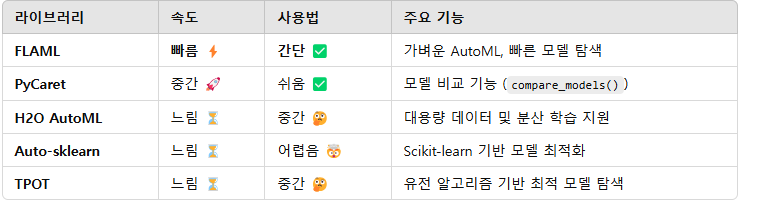

참고)

### Numba
 - Python 및 Numpy 코드의 하위 집합을 빠른 기계 코드로 변환하는 오픈소스 Jit 컴파일러.

 - Just In Time 컴파일러를 사용해 파이썬 코드 내에서 일반 코드 및 Numpy를 아주 빠른 속도로 처리 가능한 기능을 제공.

- 공식문서에 설명
    - Numba makes Python code fast.
    - Numba is an open source JIT compiler that translates a subset of Python and NumPy code into fast machine code.

- Numbda 작동원리
    - 데커레이팅된 함수에 대한 파이썬 bytecode를 읽고 이를 함수의 입력 인수 유형에 대한 정보와 결합한다,.
    - 코드를 분석하고 최적화한 후, LLVM compiler library를 사용하여 함수의 machine code 버전을 만들고, 이를 사용자의 CPU 능력에 맞춤.
    - 이 complied된 버전이 앞으로 그 함수를 호출할 때마다 사용된다.

- Numbda 모듈이 모든 파이썬 코드를 최적화 해주는 것은 아니다. 일부 파이썬 코드와 Numpy 대해서만 작동하며 다른 모듈을 이용한 코드를 최적화 시켜주지는 못한다. ex)Numbda는 Pandas를 이해하지 못함. 특정 목적에 따라 충분히 활용할 수 있는 가치가 있는 모듈.

In [ ]:
from time import perf_counter
from numba import jit

# 일반적인 loop
def pure_sum(n):
    result = 0
    for i in range(0, n+1):
        result += i
    return result

# Numba 모듈 사용
@jit(nopython=True, cache=True)
def numba_sum(n):
    result = 0
    for i in range(0, n+1):
        result += i
    return result

# 시간 재기: 일반
start = perf_counter()
pure_sum(100000000)
print(perf_counter() - start)

# 시간 재기에 앞서 먼저 Compile을 해준다.
numba_sum(1)

# 시간 재기: Numba
start = perf_counter()
numba_sum(100000000)
print(perf_counter() - start)

- @jit 데커레이터의 모드
    - @jit 데커레이터는 nopython과 object라는 2가지 compilation 모드로 작동한다.
    - 위 예제에서 nopython=True를 통해 Numba에게 nopython 모드로 작동하라고 지시한 셈인데, 이 모드는 decorate된 function을 근본적으로 compile하여 Python Interpreter의 개입 없이 전체가 작동하도록 한다.
    - 만약 nopython 모드가 잘 작동하지 않을 경우, Numba은 object 모드를 통해 compile 할 수 있다. @jit(nopython=True)가 아닌 @jit이라고만 데커레이팅하면 이 모드가 작동하게 된다.
    - 본 모드에서는 Numba은 loop를 식별하여 machine code에서 compile하며 나머지는 Intereter code에서 compile하게 된다. 더 나은 성능을 기대한다면 이 모드가 아닌 nopython 모드를 사용해야 한다.
    

- 참고 : Polars(https://realpython.com/polars-python/)
- 참고 : Dask(https://data-science-note.tistory.com/67)